In [1]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/MSc_Thesis/'

import os
os.chdir(project_path)

Mounted at /content/drive


In [2]:
import numpy as np
from utils.helpers_functions import denormalize_mae, read_dataset,mean_with_land_mask, mean_with_coastline_mask
from utils.display_functions import plot_to_compare, plot_history, plot_per_pixel_metrics, plot_degrees_mae, plot_mask_grid
from utils.models_functions import psnr, ssim, load_model, save_model, train_model
from utils.evaluation_functions import evaluate_per_pixel

dates_path='input_data/index/'
lr_data_path='input_data/deg/0_5x0_5/'
hr_data_path='input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (320, 580)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model

# Residual Block (Keeping Filters Constant)
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)  # Scale residual output
    return Add()([x, res])  # Skip connection within residual block

def create_edsr():
    input_img = Input(shape=(160, 290, 1))  # Low-resolution input

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(input_img)
    # x = LeakyReLU(alpha=0.2)(x)

    # Residual Blocks (Feature Extraction)
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    x = Add()([x, initial_conv])

    # Upsampling Layer moved to the end
    x = UpSampling2D(size=(2, 2))(x)  # Upscale to (160, 290)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [4]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(project_path, dates_path, lr_data_path, hr_data_path, \
                                                                                         'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)

(21478, 160, 290, 1)
(21478, 320, 580, 1)
(4602, 160, 290, 1)
(4602, 320, 580, 1)


In [ ]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 290, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 160, 290, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 160, 290, 32)   │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 160, 290, 32)   │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 160, 290, 32)   │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 160, 290, 32)   │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ leaky_re_lu_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 160, 290, 32)   │              0 │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 160, 290, 32)   │              0 │ add_5[0][0],           │
│                           │                        │                │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 160, 290, 32)   │              0 │ conv2d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 160, 290, 32)   │          9,248 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 160, 290, 32)   │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 160, 290, 32)   │              0 │ add_6[0][0],           │
│                           │                        │                │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)   

 Total params: 83,841 (327.50 KB)

 Trainable params: 83,841 (327.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
336/336 ━━━━━━━━━━━━━━━━━━━━ 93s 211ms/step - loss: 0.0273 - mae: 0.0273 - mse: 0.0061 - psnr: 32.4984 - ssim: 0.9018 - val_loss: 0.0037 - val_mae: 0.0037 - val_mse: 5.0156e-05 - val_psnr: 42.9993 - val_ssim: 0.9902 - learning_rate: 0.0010
Epoch 2/1000
336/336 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - loss: 0.0037 - mae: 0.0037 - mse: 4.5260e-05 - psnr: 43.4800 - ssim: 0.9903 - val_loss: 0.0038 - val_mae: 0.0038 - val_mse: 3.6505e-05 - val_psnr: 44.3778 - val_ssim: 0.9908 - learning_rate: 0.0010
Epoch 3/1000
336/336 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step - loss: 0.0035 - mae: 0.0035 - mse: 3.3954e-05 - psnr: 44.7004 - ssim: 0.9908 - val_loss: 0.0030 - val_mae: 0.0030 - val_mse: 2.8715e-05 - val_psnr: 45.4198 - val_ssim: 0.9908 - learning_rate: 0.0010
Epoch 4/1000
336/336 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - loss: 0.0031 - mae: 0.0031 - mse: 2.9605e-05 - psnr: 45.2945 - ssim: 0.9909 - val_loss: 0.0033 - val_mae: 0.0033 - val_mse: 3.1116e-05 - val_psnr: 45.0715 - val_ssim: 0.9911 

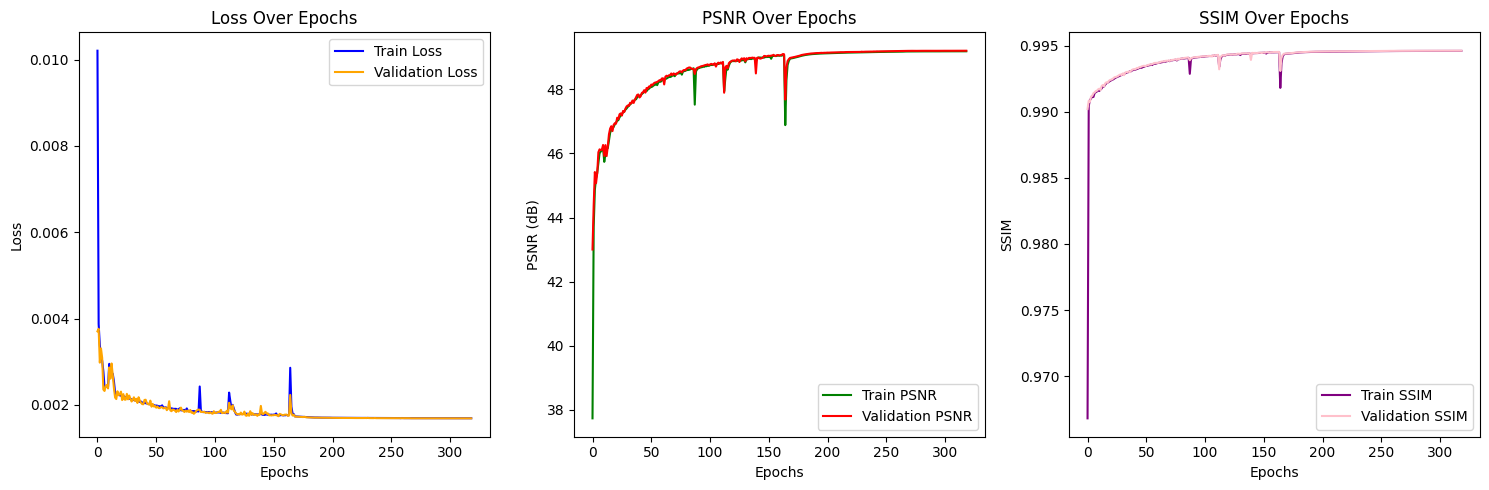

In [ ]:
import time

start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 1000, 64, True, True, 150, 100)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")


plot_history(history)
save_model(edsr_model, 'models/edsr_model_0_5to0_25_deg_all.keras')

In [5]:
edsr_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_all.keras', custom_objects={'psnr': psnr, 'ssim': ssim}, safe_mode=False)

In [6]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.0017 - mae: 0.0017 - mse: 1.2711e-05 - psnr: 48.9636 - ssim: 0.9944
Test Loss: 0.0017331165727227926
Test PSNR: 48.96379470825195
Test SSIM: 0.9943664073944092
Test MSE: 1.2710651390079875e-05
Test MAE: 0.0017331165727227926


In [7]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


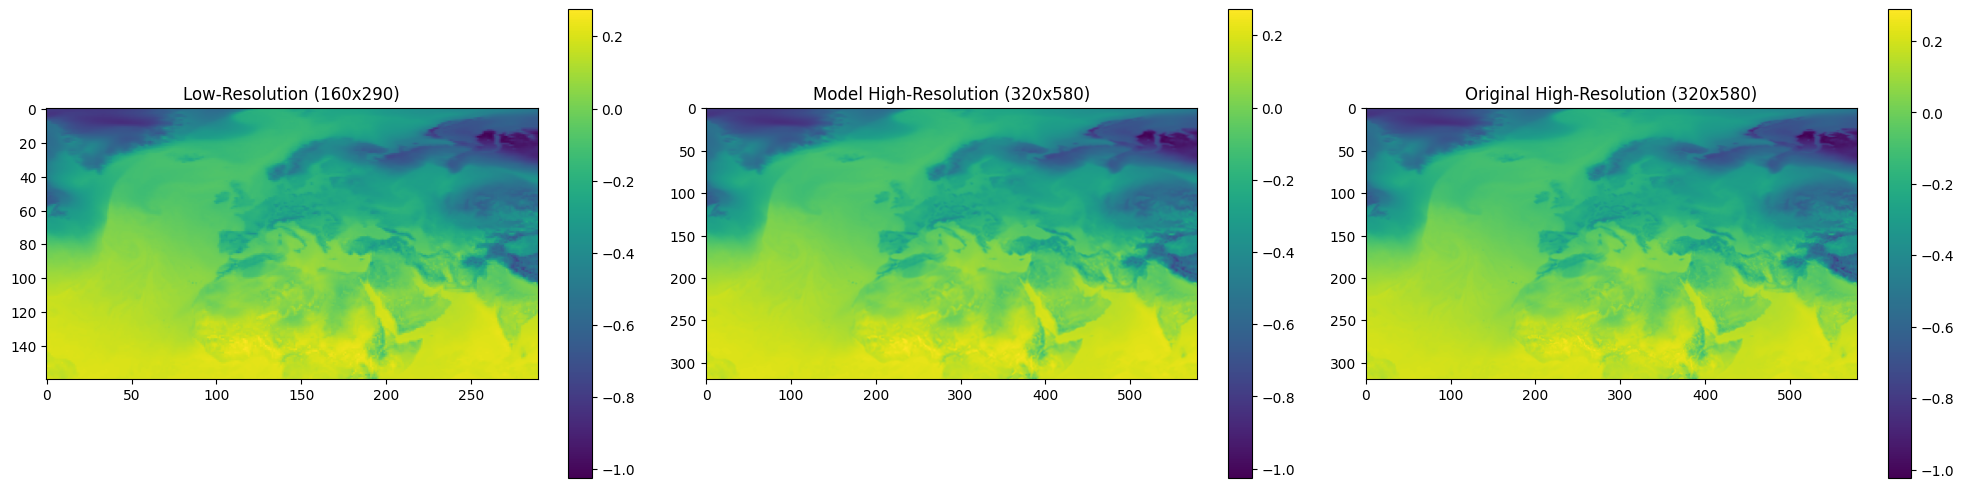

In [8]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

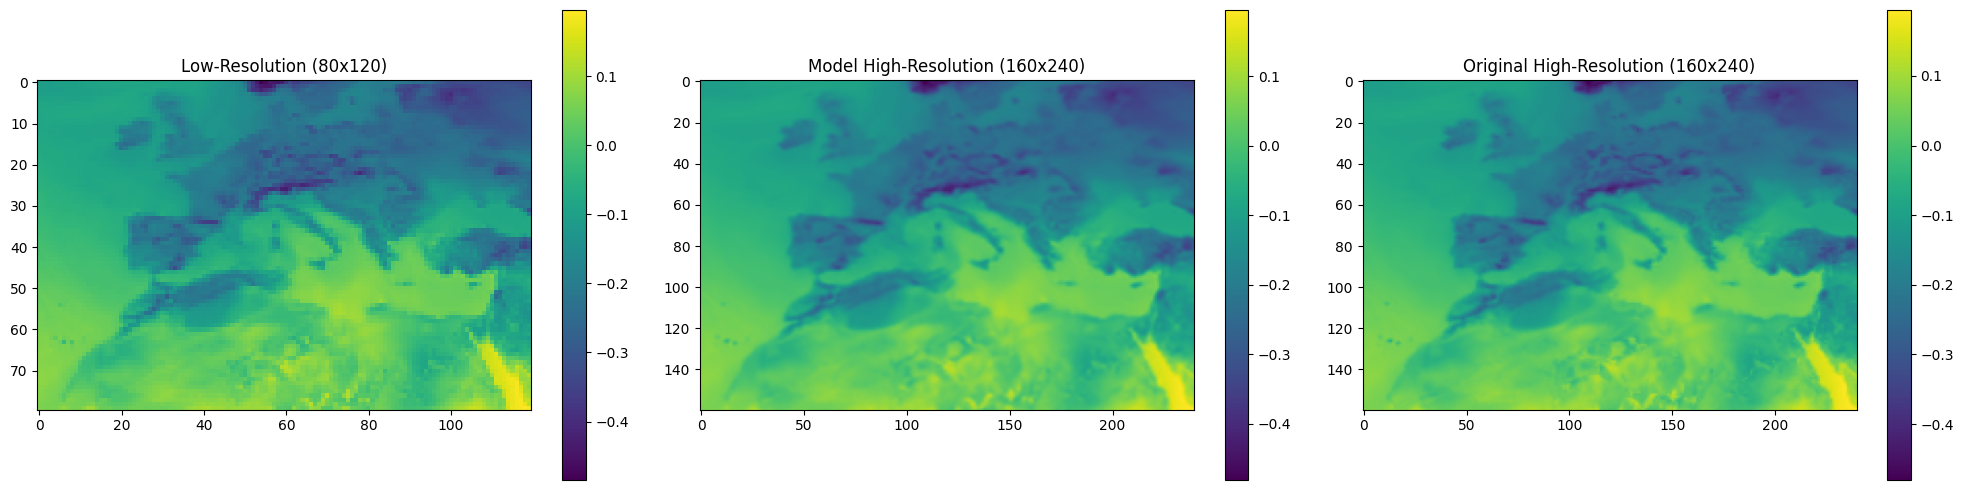

In [10]:
plot_to_compare(low_res_input[40:120, 80:200], np.squeeze(high_res_data)[80:240, 160:400],  np.squeeze(high_res_output)[80:240, 160:400], 'viridis')

In [11]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 1.2710648e-05
Mean Per-Pixel MAE: 0.0017331162
Mean Per-Pixel PSNR: 56.42159
Mean Per-Pixel SSIM: 0.99837637


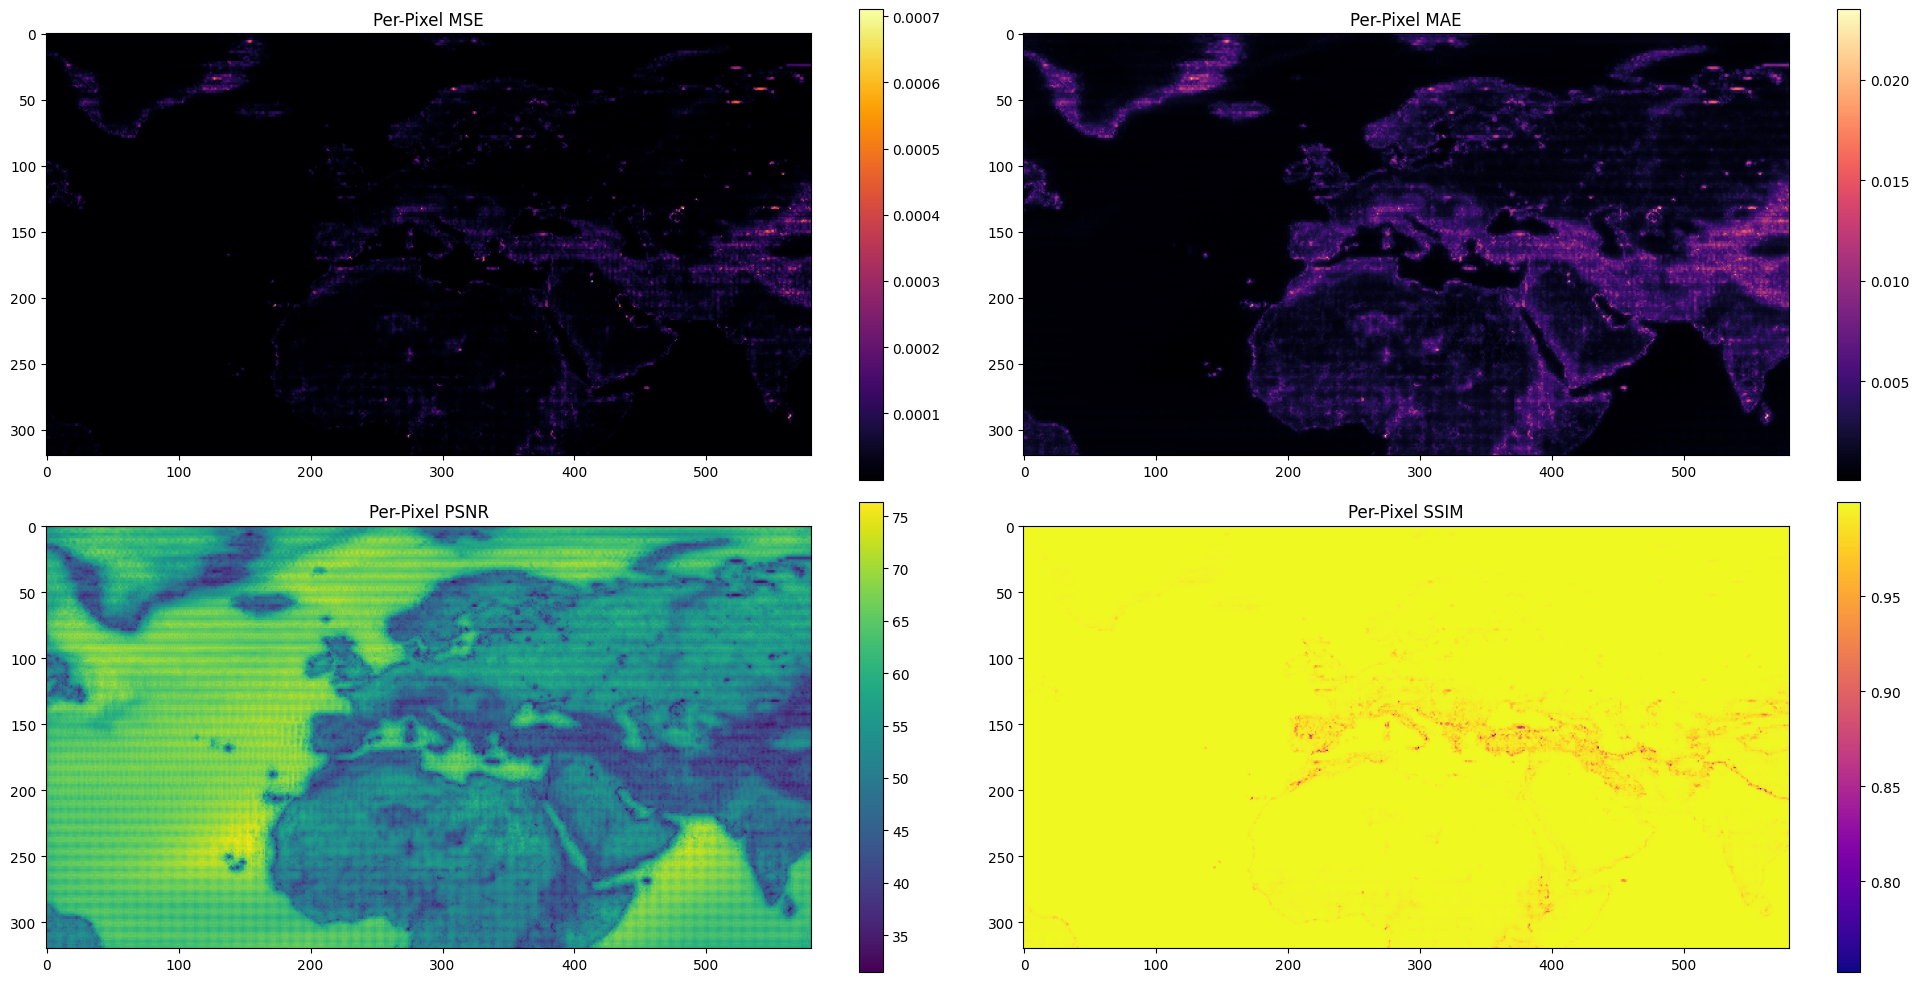

In [12]:
# Plot results
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.11136453
Max Degrees MAE: 1.5113726
Min Degrees MAE: 0.006600467


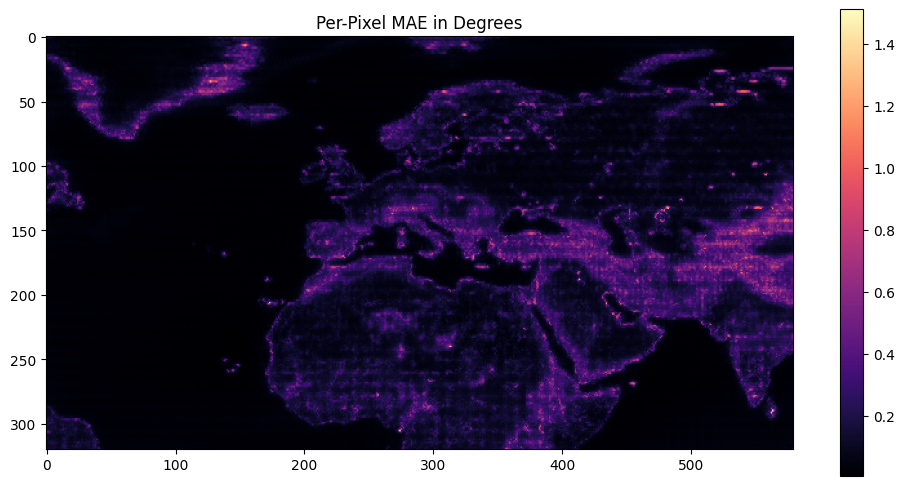

In [13]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [15]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.17695098
Mean Land-Pixels MAE: 0.0027538093


In [16]:
print("Mean Coastline-Pixels Degrees MAE:", mean_with_coastline_mask(degrees_mae, '0_25'))
print("Mean Costline-Pixels MAE:", mean_with_coastline_mask(test_mae, '0_25'))

Mean Coastline-Pixels Degrees MAE: 0.29531637
Mean Costline-Pixels MAE: 0.0045958767
